In [1]:
! pwd
DATASET = 'CIFAR-100'
cifar_train = True
data_path = None
if DATASET == 'ImageNet':
    data_path = '/nobackup-slow/dataset/ILSVRC-2012/train'
elif DATASET == 'CIFAR-10' or DATASET == 'CIFAR-100':
    data_path = '/nobackup-slow/dataset/cifarpy'
else:
    data_path = '/nobackup-slow/dataset/ImageNet_OOD_dataset/{}'.format(DATASET)
sg_benchmark_path = '/nobackup-fast/ziyangc/scene_graph_benchmark'
oscar_path = '/nobackup-fast/ziyangc/Oscar'

/afs/cs.wisc.edu/u/z/i/ziyangc/Github/CLIP_OOD


In [24]:
# TODO: delete this cell
import sys
sys.path.append('/nobackup-fast/ziyangc/scene_graph_benchmark')
import maskrcnn_benchmark

In [25]:
import base64
import cv2
import json
import os.path as op
import os
import yaml
from tqdm import tqdm
from maskrcnn_benchmark.structures.tsv_file_ops import tsv_reader, tsv_writer
from maskrcnn_benchmark.structures.tsv_file_ops import generate_linelist_file
from maskrcnn_benchmark.structures.tsv_file_ops import generate_hw_file
from maskrcnn_benchmark.structures.tsv_file import TSVFile
from maskrcnn_benchmark.data.datasets.utils.image_ops import img_from_base64

# To generate a tsv file:
get_class_name = {
    'ImageNet': lambda p, f: p.split('/')[-1],
    'iNaturalist': lambda p, f: 'OOD',
    'Places': lambda p, f: f.split('_')[1],
    'Textures': lambda p, f: p.split('/')[-1],
    'SUN': lambda p, f: 'OOD'
}

filter_classes = {
    'ImageNet': True,
    'iNaturalist': False,
    'Places': False,
    'Textures': False,
    'SUN': False
}

test_classes = {'n04552348', 'n04285008', 'n01530575', 'n02123597', 'n02422699', 'n02107574', 'n01641577', 'n01728572', 'n03095699', 'n03417042'}
tsv_data_path = os.path.join(sg_benchmark_path, 'tools/mini_tsv/data/')
ImageNet_classes = {key: string for [key, string] in json.load(open("/nobackup-fast/ziyangc/imagenet_class_index.json")).values()}
img_list = [(path, f) for (path, _, files) in os.walk(data_path) for f in files if (f.lower().endswith(".jpeg") or f.lower().endswith('jpg')) and (not filter_classes[DATASET] or path.split('/')[-1] in test_classes)]
tsv_file = "{}.test.tsv".format(DATASET)
label_file = "{}.test.label.tsv".format(DATASET)
hw_file = "{}.test.hw.tsv".format(DATASET)
linelist_file = "{}.test.linelist.tsv".format(DATASET)

rows = []
rows_label = []
rows_hw = []
for (path, filename) in tqdm(img_list):
    class_name =  get_class_name[DATASET](path, filename)
    img_key = class_name + '_' + filename.split('.')[0]
    img_path = op.join(path, filename)
    img = cv2.imread(img_path)
    if img is None: continue
    img_encoded_str = base64.b64encode(cv2.imencode('.jpg', img)[1])

    # Here is just a toy example of labels.
    # The real labels can be generated from the annotation files
    # given by each dataset. The label is a list of dictionary
    # where each box with at least "rect" (xyxy mode) and "class"
    # fields. It can have any other fields given by the dataset.
    height = img.shape[0]
    width = img.shape[1]

    labels = []
    # labels.append({"rect": [1, 1, height, width], "class": ImageNet_classes[class_name]})
    labels.append({"rect": [1, 1, height, width], "class": class_name})

    row = [img_key, img_encoded_str]
    rows.append(row)

    row_label = [img_key, json.dumps(labels)]
    rows_label.append(row_label)

    row_hw = [img_key, json.dumps([{"height": height, "width": width}])]
    rows_hw.append(row_hw)

tsv_writer(rows, os.path.join(tsv_data_path, tsv_file))
tsv_writer(rows_label, os.path.join(tsv_data_path, label_file))
tsv_writer(rows_hw, os.path.join(tsv_data_path, hw_file))

# generate linelist file
generate_linelist_file(os.path.join(tsv_data_path, label_file), save_file=os.path.join(tsv_data_path, linelist_file))

yaml_dict = {"img": tsv_file,
            "label": label_file,
            "hw": hw_file,
            "linelist": linelist_file}

with open(op.join(tsv_data_path, '{}.test.yaml'.format(DATASET)), 'w') as file:
        yaml.dump(yaml_dict, file)

# To access a tsv file:
# 1) Use tsv_reader to read dataset in given order
# rows = tsv_reader("tools/mini_tsv/data/train.tsv")
# rows_label = tsv_reader("tools/mini_tsv/data/train.label.tsv")
# for row, row_label in zip(rows, rows_label):
#     img_key = row[0]
#     labels = json.loads(row_label[1])
#     img = img_from_base64(row[1])

# 2) use TSVFile to access dataset at any given row.
# tsv = TSVFile("tools/mini_tsv/data/train.tsv")
# row = tsv.seek(1) # to access the second row
# img_key = row[0]
# img = img_from_base64(row[1])

100%|██████████| 10000/10000 [06:20<00:00, 26.28it/s]
9997it [00:00, 257892.34it/s]


In [3]:
import base64
import cv2
import json
import os.path as op
import os
import yaml
import numpy as np
from tqdm import tqdm
from maskrcnn_benchmark.structures.tsv_file_ops import tsv_reader, tsv_writer
from maskrcnn_benchmark.structures.tsv_file_ops import generate_linelist_file
from maskrcnn_benchmark.structures.tsv_file_ops import generate_hw_file
from maskrcnn_benchmark.structures.tsv_file import TSVFile
from maskrcnn_benchmark.data.datasets.utils.image_ops import img_from_base64
from torchvision import datasets

# To generate a tsv file:
if not cifar_train: DATASET = DATASET + '-val'
tsv_data_path = os.path.join(sg_benchmark_path, 'tools/mini_tsv/data/')
if DATASET == 'CIFAR-10':
    img_ds = datasets.CIFAR10(data_path, train=cifar_train)
elif DATASET == 'CIFAR-100':
    img_ds = datasets.CIFAR100(data_path, train=cifar_train)
tsv_file = "{}.test.tsv".format(DATASET)
label_file = "{}.test.label.tsv".format(DATASET)
hw_file = "{}.test.hw.tsv".format(DATASET)
linelist_file = "{}.test.linelist.tsv".format(DATASET)
return 
rows = []
rows_label = []
rows_hw = []
for i, (img, target) in tqdm(enumerate(img_ds)):
    class_name =  img_ds.classes[target]
    img_key = class_name + '_' + str(i)
    if img is None: continue
    img = np.array(img)
    img_encoded_str = base64.b64encode(cv2.imencode('.jpg', img)[1])

    height = img.shape[0]
    width = img.shape[1]

    labels = []
    # labels.append({"rect": [1, 1, height, width], "class": ImageNet_classes[class_name]})
    labels.append({"rect": [1, 1, height, width], "class": class_name})

    row = [img_key, img_encoded_str]
    rows.append(row)

    row_label = [img_key, json.dumps(labels)]
    rows_label.append(row_label)

    row_hw = [img_key, json.dumps([{"height": height, "width": width}])]
    rows_hw.append(row_hw)

tsv_writer(rows, os.path.join(tsv_data_path, tsv_file))
tsv_writer(rows_label, os.path.join(tsv_data_path, label_file))
tsv_writer(rows_hw, os.path.join(tsv_data_path, hw_file))

# generate linelist file
generate_linelist_file(os.path.join(tsv_data_path, label_file), save_file=os.path.join(tsv_data_path, linelist_file))

yaml_dict = {"img": tsv_file,
            "label": label_file,
            "hw": hw_file,
            "linelist": linelist_file}

with open(op.join(tsv_data_path, '{}.test.yaml'.format(DATASET)), 'w') as file:
        yaml.dump(yaml_dict, file)

SyntaxError: 'return' outside function (3455061386.py, line 27)

In [4]:
! ls {tsv_data_path}

CIFAR-100.test.hw.lineidx	 ImageNet.test.linelist.lineidx
CIFAR-100.test.hw.tsv		 ImageNet.test.linelist.tsv
CIFAR-100.test.label.lineidx	 ImageNet.test.tsv
CIFAR-100.test.label.tsv	 ImageNet.test.yaml
CIFAR-100.test.lineidx		 SUN.test.hw.lineidx
CIFAR-100.test.linelist.lineidx  SUN.test.hw.tsv
CIFAR-100.test.linelist.tsv	 SUN.test.label.lineidx
CIFAR-100.test.tsv		 SUN.test.label.tsv
CIFAR-100.test.yaml		 SUN.test.lineidx
CIFAR-10.test.hw.lineidx	 SUN.test.linelist.lineidx
CIFAR-10.test.hw.tsv		 SUN.test.linelist.tsv
CIFAR-10.test.label.lineidx	 SUN.test.tsv
CIFAR-10.test.label.tsv		 SUN.test.yaml
CIFAR-10.test.lineidx		 train.hw.lineidx
CIFAR-10.test.linelist.lineidx	 train.hw.tsv
CIFAR-10.test.linelist.tsv	 train.label.lineidx
CIFAR-10.test.tsv		 train.labelmap.tsv
CIFAR-10.test.yaml		 train.label.tsv
ImageNet.test.hw.lineidx	 train.lineidx
ImageNet.test.hw.tsv		 train.linelist.tsv
ImageNet.test.label.lineidx	 train.tsv
ImageNet.test.label.tsv		 train.yaml
ImageNet.test.lineidx


In [ ]:
! wget https://penzhanwu2.blob.core.windows.net/sgg/sgg_benchmark/vinvl_model_zoo/vinvl_vg_x152c4.pth -P {sg_benchmark_path}/pretrained_model
! wget https://penzhanwu2.blob.core.windows.net/sgg/sgg_benchmark/vinvl_model_zoo/VG-SGG-dicts-vgoi6-clipped.json -P {sg_benchmark_path}/visualgenome/

In [3]:
! cd {sg_benchmark_path} && rm -rf output/{DATASET}
! cd {sg_benchmark_path} && conda activate oscar && CUDA_VISIBLE_DEVICES=6,7 python -m torch.distributed.launch --nproc_per_node=2 tools/test_sg_net.py \
  --config-file sgg_configs/vgattr/vinvl_x152c4.yaml \
  TEST.IMS_PER_BATCH 2 \
  DATASETS.TEST "('{DATASET}.test.yaml', )"\
  MODEL.WEIGHT pretrained_model/vinvl_vg_x152c4.pth \
  MODEL.ROI_HEADS.NMS_FILTER 1 \
  MODEL.ROI_HEADS.SCORE_THRESH 0.2 \
  TEST.OUTPUT_FEATURE True \
  OUTPUT_DIR output/{DATASET} \
  DATA_DIR tools/mini_tsv/data \
  TEST.IGNORE_BOX_REGRESSION True \
  MODEL.ATTRIBUTE_ON True \
  DATASETS.LABELMAP_FILE visualgenome/VG-SGG-dicts-vgoi6-clipped.json

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
2022-04-02 12:03:30,392 maskrcnn_benchmark INFO: Using 2 GPUs
2022-04-02 12:03:30,392 maskrcnn_benchmark INFO: DATALOADER:
  ASPECT_RATIO_GROUPING: True
  NUM_WORKERS: 0
  SIZE_DIVISIBILITY: 0
DATASETS:
  FACTORY_TEST: ('VGTSVDataset',)
  FACTORY_TRAIN: ('VGTSVDataset',)
  LABELMAP_FILE: visualgenome/VG-SGG-dicts-vgoi6-clipped.json
  TEST: ('CIFAR-100.test.yaml',)
  TRAIN: ('visualgenome/train_vgoi6_clipped.yaml',)
DATA_DIR: tools/mini_tsv/data
DISTRIBUTED_BACKEND: gloo
DTYPE: float32
INPUT:
  BRIGHTNESS: 0.0
  CONTRAST: 0.0
  HORIZONTAL_FLIP_PROB_TRAIN: 0.5
  HUE: 0.0
  MAX_SIZE_TEST: 1000
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 600
  MIN_SIZE_TRAIN: (800,)
  PIXEL_MEAN: [103.53, 116.28, 123.675]

In [4]:
import pandas as pd
import os
import json
import ast
import numpy as np
import base64

data_dir = os.path.join(sg_benchmark_path, 'tools/mini_tsv/data')
sg_tsv = os.path.join(sg_benchmark_path, 'output/{}/inference/vinvl_vg_x152c4/predictions.tsv'.format(DATASET))

# Height and width data
hw_df = pd.read_csv(os.path.join(data_dir, '{}.test.hw.tsv'.format(DATASET)), sep='\t', header=None, converters={1:ast.literal_eval}, index_col=0)
print(hw_df.head())

# bboxes, class, confidence and spacial features
df = pd.read_csv(sg_tsv, sep='\t', header=None, converters={1:json.loads})
df[1] = df[1].apply(lambda x:x['objects'])
print(df.head())

def generate_additional_features(rect, h, w):
    mask = np.array([w, h, w, h], dtype=np.float32)
    rect = np.clip(rect / mask, 0, 1)
    res = np.hstack((rect, (rect[3] - rect[1], rect[2] - rect[0])))
    return res.astype(np.float32)

def generate_features(x):
    idx, data, num_boxes = x[0], x[1], len(x[1] )
    h, w, features_arr = hw_df.loc[idx, 1][0]['height'], hw_df.loc[idx,1][0]['width'], []

    for i in range(num_boxes):
        features = np.frombuffer(base64.b64decode(data[i]['feature']),np.float32)
        pos_feat = generate_additional_features(data[i]['rect'],h,w)
        x = np.hstack((features,pos_feat))
        features_arr.append(x.astype(np.float32))

    features = np.vstack(tuple(features_arr))
    features = base64.b64encode(features).decode("utf-8")
    return {"features":features, "num_boxes":num_boxes}

def generate_labels(x):
    data = x[1]
    res = [{"class":el['class'].capitalize(),"conf":el['conf'], "rect": el['rect']} for el in data]
    return res

df['feature'] = df.apply(generate_features,axis=1)
df['feature'] = df['feature'].apply(json.dumps)

df['label'] = df.apply(generate_labels,axis=1)
df['label'] = df['label'].apply(json.dumps)

print(df.head())

output_dir = os.path.join(oscar_path, 'oscar/my_data')
label_file = os.path.join(output_dir, '{}.label.tsv'.format(DATASET))
feature_file = os.path.join(output_dir, '{}.features.tsv'.format(DATASET))

from maskrcnn_benchmark.structures.tsv_file_ops import tsv_reader, tsv_writer
tsv_writer(df[[0,'label']].values.tolist(), label_file)
tsv_writer(df[[0,'feature']].values.tolist(), feature_file)

import yaml
import os.path as op
yaml_dict = {"label": '{}.label.tsv'.format(DATASET),
             "feature": '{}.features.tsv'.format(DATASET)}

with open(op.join(output_dir, '{}.test.yaml'.format(DATASET)), 'w') as file:
        yaml.dump(yaml_dict, file)

                                             1
0                                             
cattle_0         [{'height': 32, 'width': 32}]
dinosaur_1       [{'height': 32, 'width': 32}]
apple_2          [{'height': 32, 'width': 32}]
boy_3            [{'height': 32, 'width': 32}]
aquarium_fish_4  [{'height': 32, 'width': 32}]
                 0                                                  1
0         cattle_0  [{'rect': [15.091263771057129, 18.420007705688...
1       dinosaur_1  [{'rect': [8.743090629577637, 21.0789527893066...
2          apple_2  [{'rect': [0.0, 0.0, 19.87682342529297, 26.465...
3            boy_3  [{'rect': [9.654656410217285, 6.23761081695556...
4  aquarium_fish_4  [{'rect': [0.0, 9.214780807495117, 21.26975631...
                 0                                                  1  \
0         cattle_0  [{'rect': [15.091263771057129, 18.420007705688...   
1       dinosaur_1  [{'rect': [8.743090629577637, 21.0789527893066...   
2          apple_2  [{'rect': [0

In [5]:
! cd {oscar_path} && conda activate oscar && CUDA_VISIBLE_DEVICES=5,6,7 python -m torch.distributed.launch --nproc_per_node=3 oscar/run_captioning.py \
    --eval_model_dir pretrained_models/image_captioning/coco_captioning_large_scst/checkpoint-4-50000/\
    --do_test \
    --test_yaml oscar/my_data/{DATASET}.test.yaml \
    --do_lower_case \
    --add_od_labels \
    --output_dir output/ \
    --num_workers 0

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Init distributed training on local rank 0
Init distributed training on local rank 1
Init distributed training on local rank 7
Init distributed training on local rank 6
Init distributed training on local rank 3
Init distributed training on local rank 4
Init distributed training on local rank 2
Init distributed training on local rank 5
Device: cuda, n_gpu: 8
Device: cuda, n_gpu: 8
Device: cuda, n_gpu: 8
2022-03-15 14:17:13,088 vlpretrain WARNING: Device: cuda, n_gpu: 8
Device: cuda, n_gpu: 8
Device: cuda, n_gpu: 8
Device: cuda, n_gpu: 8
Device: cuda, n_gpu: 8
2022-03-15 14:17:13,158 vlpretrain WARNING: Override max_seq_length to 50 = max_gen_length:20 + od_labels_len:30
Override max_seq_length to 50

In [7]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
import numpy as np

coco_inf_path = os.path.join(oscar_path, 'pretrained_models/image_captioning/coco_captioning_large_scst/checkpoint-4-50000/pred.coco_caption.{}.test.beam1.max20.odlabels.tsv'.format(DATASET))

df = pd.read_csv(coco_inf_path, sep='\t')
df.columns = ['img', 'raw_data']
objects = df.iloc[:,1].apply(json.loads)
df['caption'] = objects.apply(lambda x: x[0]['caption'])
df['conf'] = objects.apply(lambda x: x[0]['conf'])
df['class'] = df['img'].apply(lambda x: x.split('_')[0])
df['img'] = df['img'].apply(lambda x: '_'.join(x.split('_')[1:]))
print(df.head())


      img                                           raw_data  \
0       1  [{"caption": "a green statue of a man standing...   
1       2  [{"caption": "a blurry picture of a purple obj...   
2       3  [{"caption": "a blurry picture of a person wit...   
3  fish_4  [{"caption": "a blurry image of a building in ...   
4       5  [{"caption": "a blurry picture of a blue and w...   

                                             caption      conf      class  
0  a green statue of a man standing in front of a...  0.812326   dinosaur  
1    a blurry picture of a purple object in the air.  0.868000      apple  
2    a blurry picture of a person with a blue shirt.  0.934274        boy  
3    a blurry image of a building in the background.  0.893749   aquarium  
4       a blurry picture of a blue and white object.  0.957596  telephone  


In [49]:
fig = plt.figure(dpi = 100, figsize=[20,20])

N = 6
for c, i in enumerate(np.random.randint(0, len(df), size=N)):
    test_image = str(df.iloc[i]['img'])+'.jpg'
    test_class = str(df.iloc[i]['class'])
    if DATASET in ['iNaturalist', 'Places', 'SUN']: test_class = 'images'
    test_caption = df.iloc[i]['caption']

    try:
        img = Image.open(os.path.join(data_path, test_class, test_image))
    except:
        img = Image.open(os.path.join(data_path, test_class, test_image))
    
    ax = fig.add_subplot(int(N/2), 2, c + 1)
    ax.imshow(img)
    ax.axis('off')
    txt = ax.text(0, -10, test_caption, wrap=True, fontsize='xx-large')
    txt._get_wrap_line_width = lambda : 800
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/nobackup-slow/dataset/cifarpy/frog/15816.jpg'

<Figure size 2000x2000 with 0 Axes>

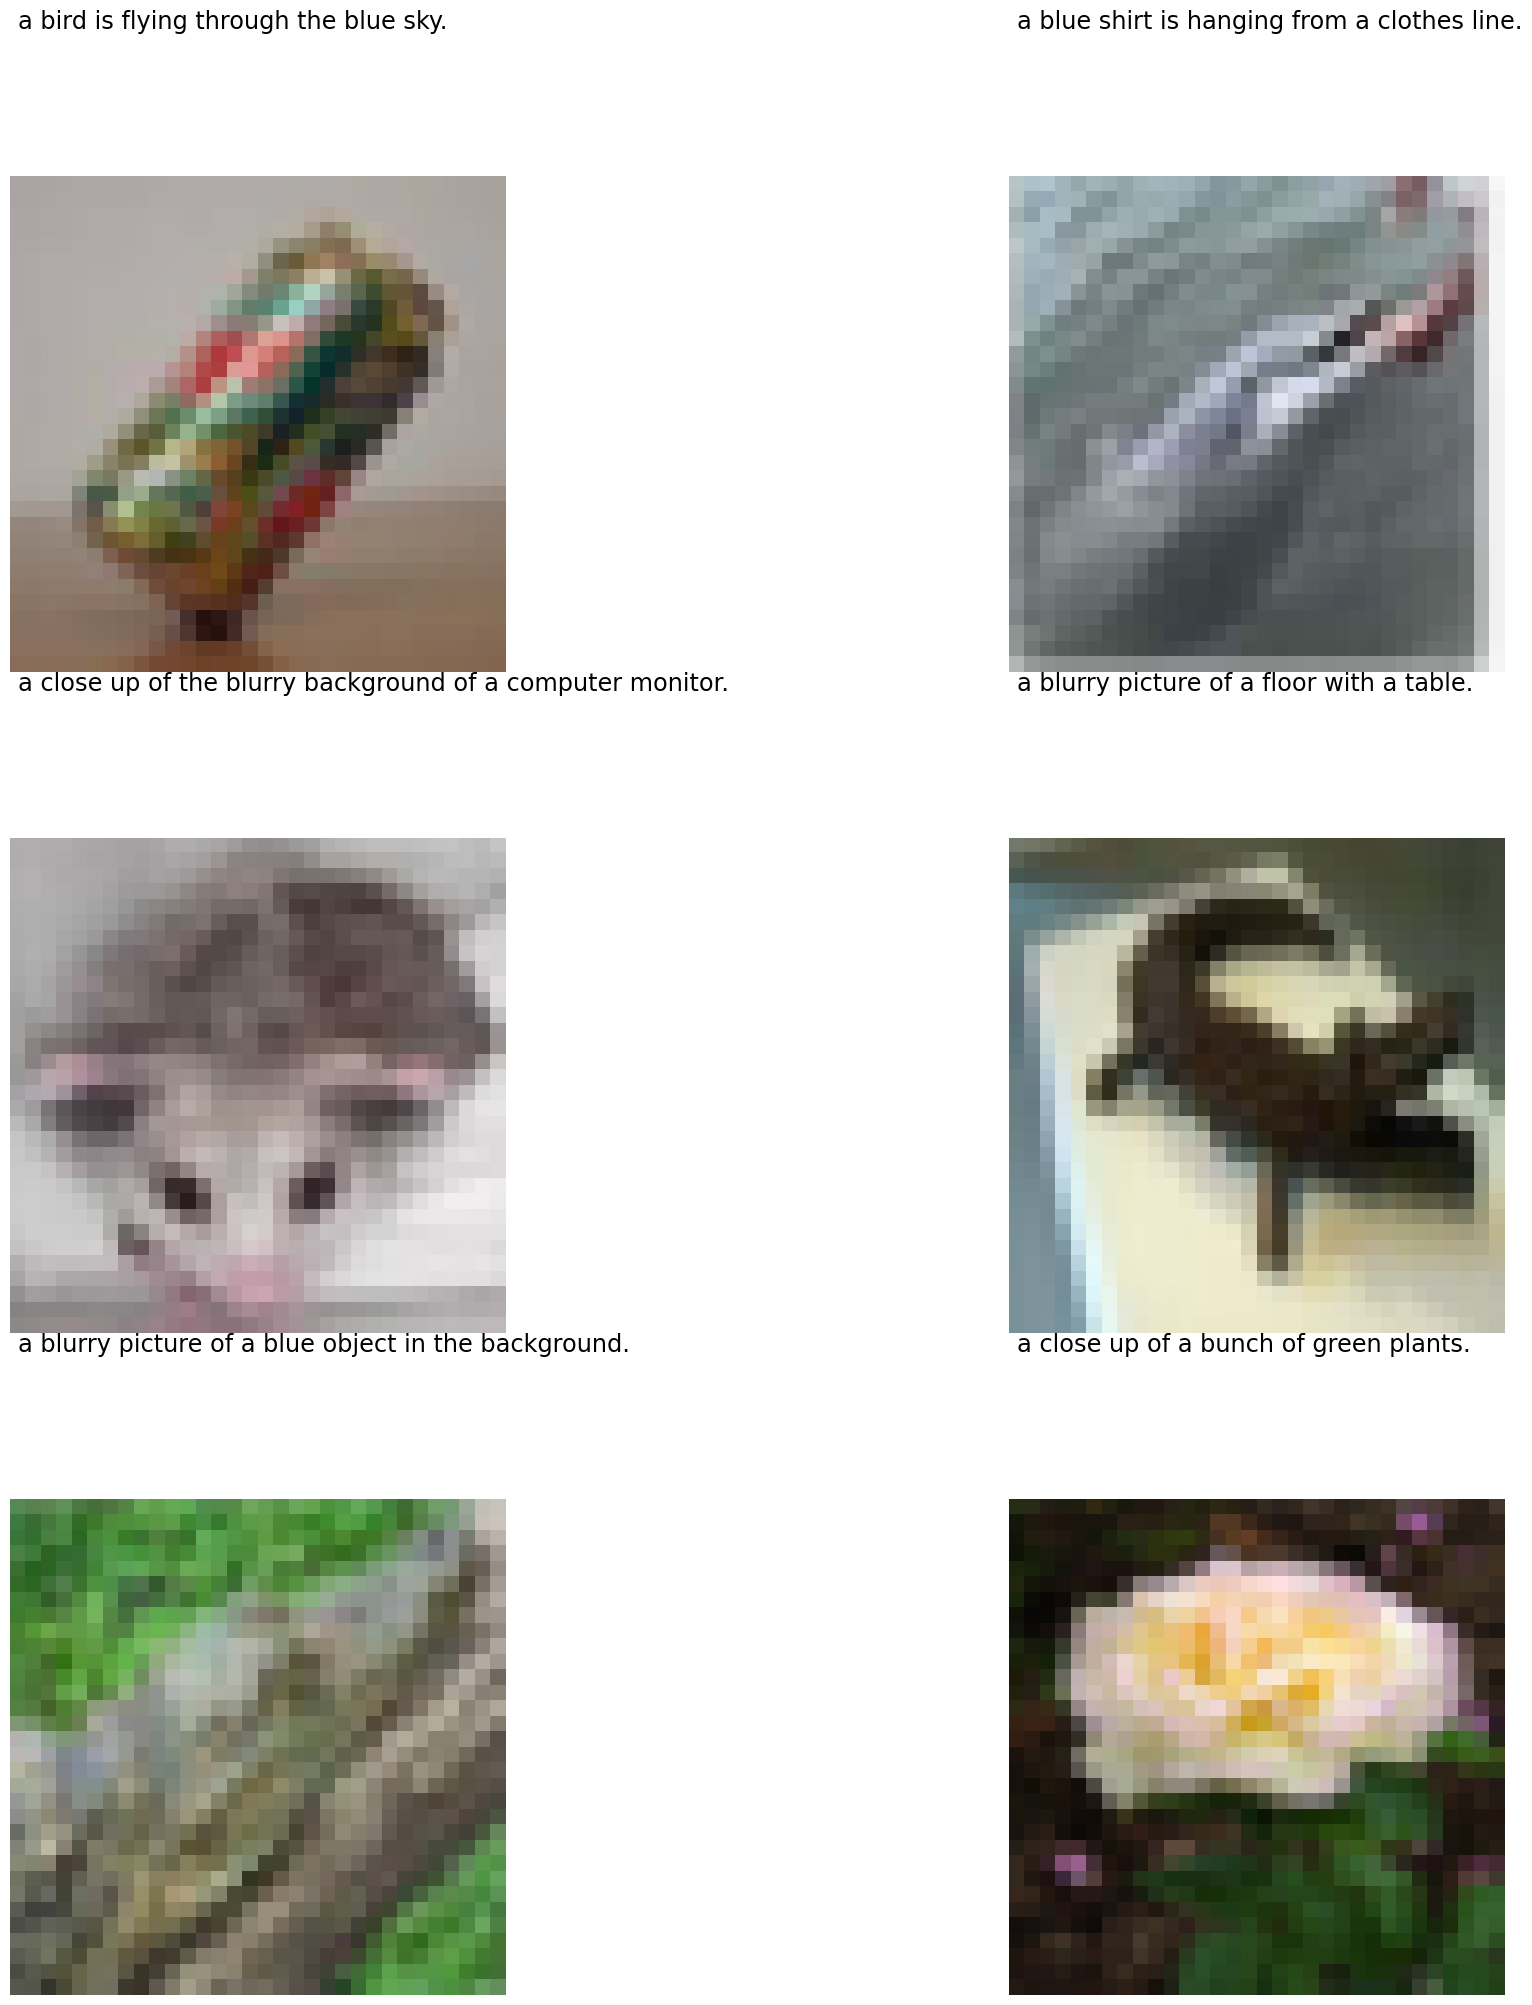

In [13]:
fig = plt.figure(dpi = 100, figsize=[20,20])

N = 6
for c, i in enumerate(np.random.randint(0, len(df), size=N)):
    img, _ = img_ds[i]
    test_caption = df.iloc[i]['caption']
    
    ax = fig.add_subplot(int(N/2), 2, c + 1)
    ax.imshow(img)
    ax.axis('off')
    txt = ax.text(0, -10, test_caption, wrap=True, fontsize='xx-large')
    txt._get_wrap_line_width = lambda : 800
plt.tight_layout()

In [50]:
df[['img', 'caption', 'class']].to_csv('{}_captions.tsv'.format(DATASET), header=None, index=False, sep='\t')
! ls

captions.ipynb	       gen_captions		    play_with_clip.py  utils
CIFAR-10_captions.tsv  img_templates		    random_test.py
data		       Interacting_with_CLIP.ipynb  README.md
eval_ood_detection.py  models			    train_clip.py


In [ ]:
temp_df = pd.read_csv('imagenet_captions.tsv', sep='\t')